In [1]:
!pip install gdown einops
!gdown --folder https://drive.google.com/drive/folders/19AWwx5tFwl5thc2tvw53dOMIfgd9jA1h

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.0 MB/s eta 0:00:00
Retrieving folder contents
Processing file 1zsCpMQawcUNvHlx2rE4L2Z9GUmwh1ljx client_dataset.json
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1zsCpMQawcUNvHlx2rE4L2Z9GUmwh1ljx
From (redirected): https://drive.google.com/uc?id=1zsCpMQawcUNvHlx2rE4L2Z9GUmwh1ljx&confirm=t&uuid=4552b531-159f-420c-8227-60cb56f9b1d1
To: /kaggle/working/Оценка уровня экспертности по резюме/client_dataset.json
100%|████████████████████████████████████████| 517M/517M [00:29<00:00, 17.4MB/s]
Download completed


In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from torch.utils.data import Dataset

In [3]:
df = pd.read_json("/kaggle/working/Оценка уровня экспертности по резюме/client_dataset.json") # Вставьте путь к вашим данным

def create_template_string(row):
    return f"Куда собеседуется кандидат: {row['position']}, Ключевые навыки кандидата: {row['key_skills']}, Опыт работы кандидата: {row['work_experience']}, Зарплатные ожидания: {row['salary']}, Компания куда собеседуется кандидат: {row['client_name']}"

df['template_string'] = df.apply(create_template_string, axis=1)

target = df['grade_proof']

tag2id = {}
id2tag = {}
for i, elem in enumerate(target.unique()):
    tag2id[elem] = i
    id2tag[i] = elem

target = target.apply(lambda x: tag2id[x])

In [18]:
model_id = "sergeyzh/rubert-tiny-turbo"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = model.to("cuda")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sergeyzh/rubert-tiny-turbo and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def tokenize_data(tokenizer, data, max_length=2048):
    return tokenizer(data, truncation=True, padding=True, max_length=max_length, return_tensors="pt")

X_train, X_val, y_train, y_val = train_test_split(df['template_string'].tolist(), target.tolist(), test_size=0.2, random_state=42, stratify=target)

X_train_tokenized = tokenize_data(tokenizer, X_train)
X_val_tokenized = tokenize_data(tokenizer, X_val)

In [6]:
class BinaryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BinaryDataset(X_train_tokenized, y_train)
val_dataset = BinaryDataset(X_val_tokenized, y_val)

In [7]:
def compute_metrics(p):
    pred, labels = p
    pred_probabilities = torch.softmax(torch.tensor(pred), dim=1)[:, 1].numpy()
    pred_labels = np.argmax(pred, axis=1)
    
    acc = accuracy_score(y_true=labels, y_pred=pred_labels)
    recall = recall_score(y_true=labels, y_pred=pred_labels, average='binary')
    precision = precision_score(y_true=labels, y_pred=pred_labels, average='binary')
    f1 = f1_score(y_true=labels, y_pred=pred_labels, average='binary')
    roc_auc = roc_auc_score(y_true=labels, y_score=pred_probabilities)
    
    return {'accuracy': acc, 'recall': recall, 'precision': precision, 'F1': f1, 'roc_auc': roc_auc}

In [19]:
class_weights = torch.tensor([1.0, 10.0]).to(model.device)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



training_args = TrainingArguments(
    output_dir='./results3',
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    eval_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1,Roc Auc
0,0.293600,0.275674,0.933728,0.664596,0.484163,0.560209,0.929040
1,0.267400,0.222981,0.948718,0.739130,0.574879,0.646739,0.946465
2,0.157500,0.250014,0.966075,0.658385,0.773723,0.711409,0.949162
4,0.002100,0.354849,0.962919,0.677019,0.721854,0.698718,0.946033


{'eval_loss': 0.2500137984752655,
 'eval_accuracy': 0.9660749506903353,
 'eval_recall': 0.6583850931677019,
 'eval_precision': 0.7737226277372263,
 'eval_F1': 0.7114093959731543,
 'eval_roc_auc': 0.9491619877869466,
 'eval_runtime': 24.3211,
 'eval_samples_per_second': 104.231,
 'eval_steps_per_second': 26.068,
 'epoch': 4.994082840236686}

In [ ]:
trainer.evaluate()

In [20]:
from huggingface_hub import login

login(token="YOUR TOKEN")
trainer.push_to_hub()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/danilka200300/results3/commit/179fd74d5fbd1746de28c18ba183d0e016c7f67e', commit_message='best-new-cool-rubert-tiny-turbo', commit_description='', oid='179fd74d5fbd1746de28c18ba183d0e016c7f67e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/danilka200300/results3', endpoint='https://huggingface.co', repo_type='model', repo_id='danilka200300/results3'), pr_revision=None, pr_num=None)

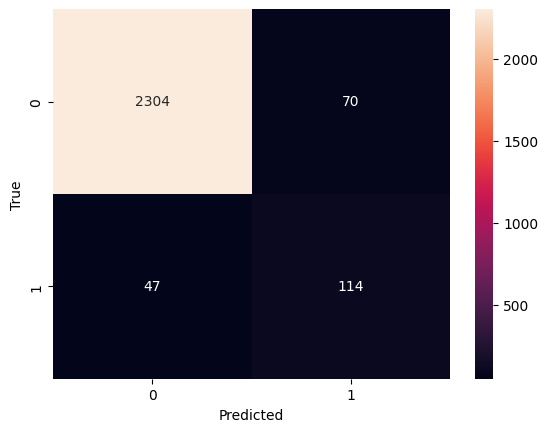

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(val_dataset)
pred_logits = predictions.predictions
true_labels = predictions.label_ids
pred_labels = np.argmax(pred_logits, axis=1)

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix

trainer.evaluate()

{'eval_loss': 0.24485546350479126,
 'eval_accuracy': 0.9439842209072978,
 'eval_recall': 0.28654970760233917,
 'eval_precision': 0.7101449275362319,
 'eval_F1': 0.4083333333333334,
 'eval_roc_auc': 0.7762601300204827,
 'eval_runtime': 2.9376,
 'eval_samples_per_second': 862.955,
 'eval_steps_per_second': 107.912,
 'epoch': 3.0}

In [23]:
len(val_dataset)

2535

In [14]:
all_text

'Куда собеседуется кандидат: 0        "программист" (по факту аналитик), отдел проек...\n1        (Повышение) Инженер отдела управления инфрастр...\n2        (Повышение) Инженер отдела управления инфрастр...\n3        (Повышение) Инженер отдела управления инфрастр...\n4        (Повышение) Инженер отдела управления инфрастр...\n                               ...                        \n12668                          старший инженер тестировщик\n12669                 старший специалист по большим данным\n12670                                         тимлид(Lead)\n12671                                 фронтэнд разработчик\n12672                                                    \u202e\nName: position, Length: 12673, dtype: object, Ключевые навыки кандидата: 0        Анализ требований, Разработка ТЗ, Управление т...\n1        Организация обработки конфиденциальной информа...\n2        Организация обработки конфиденциальной информа...\n3        Организация обработки конфиденциальной инфор

In [12]:
tag2id

{'не подтверждён': 0, 'подтверждён': 1}

In [29]:
predictions

PredictionOutput(predictions=array([[ 2.3385944, -2.210183 ],
       [ 2.3518467, -2.2100155],
       [ 2.3552248, -2.21436  ],
       ...,
       [ 2.2193232, -2.059945 ],
       [ 2.3586278, -2.2069762],
       [ 2.3785987, -2.2596772]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 0, 0]), metrics={'test_loss': 0.24485546350479126, 'test_accuracy': 0.9439842209072978, 'test_recall': 0.28654970760233917, 'test_precision': 0.7101449275362319, 'test_F1': 0.4083333333333334, 'test_roc_auc': 0.7762601300204827, 'test_runtime': 2.872, 'test_samples_per_second': 882.65, 'test_steps_per_second': 110.375})

In [33]:
val_texts = X_val.copy()
predictions = trainer.predict(val_dataset)

pred_logits = predictions.predictions
true_labels = predictions.label_ids
pred_labels = np.argmax(pred_logits, axis=1)

mask = (true_labels == 1) & (pred_labels == 0)

misclassified_texts = [val_texts[i] for i in range(len(val_texts)) if mask[i]]
for text in misclassified_texts[:5]:
    print(text)
    print("___________________________________________________________")

Куда собеседуется кандидат: Android developer, Ключевые навыки кандидата: Kotlin, Java, Git, ООП, SQL, Firebase, REST, SOAP, Websocket, MVVM, MVP, Clean Architecture, Moxy, Dagger2, Koin, Retrofit, ExoPlayer, Gson, Moshi, RxJava2, Coroutines, Room, LiveData, Flow, AndroidNavigation, Cicerone, Picasso, Glide, Jira, Slack., Опыт работы кандидата: 2022-11-01 - : Android developer  Аутстафф на проект СберТранспорт Вел команду разработки нового проекта из 3 андроид разработчиков. Активная работа с картами, REST API, разработка ui и бизнес-логики, проведение код-ревью. Полностью реализовал логику работы навигатора на основе 2gis для поездок с поддержкой остановок в промежуточных точках и переключения активного маршрута во время поездки. Доработал вложенную навигацию по экранам приложения на основе Cicerone, что повысило скорость и гибкость переключения экранов, а так же открыло новые возможности разработки.  Реализовал имплементацию встроенной в приложение камеры на основе CameraX, что повыс